<a href="https://colab.research.google.com/github/stafars/sem-3_diart_mipt_hw/blob/main/HW8_Artyushchenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Модуль 8. Аналитик качества данных



# 1. Цель

В этом блокноте одно задание - найти каскадную ошибку данных

Задание оценивается в 10 баллов:

* каскадная ошибка данных выявлена — 5 баллов.
* предоставлено грамотное объяснение почему это ошибка в данных — 3 балла.
* предложено обоснованное решение по устранению ошибки в данных — 2 балла.

Ознакомься с нижеприведённым кодом: формально в ML-конвейере есть все необходимые этапы от сбора данных до запуска модели в продуктивном окружении.


#### импорты

In [2]:
%%capture
!pip install skops "numpy>2"
!pip install matplotlib pandas scikit-learn dvc
!pip install optuna tqdm -q
!pip install seaborn imblearn
!pip install sweetviz
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import dvc.api
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sweetviz as sv
from imblearn.over_sampling import SMOTEN
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import skops.io as sio
from sklearn.metrics import accuracy_score
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import timeit
from IPython.core.display import display, HTML
le = LabelEncoder()

# 2. Создание конвейера



### Создаём новый Git-репозиторий для хранения версий данных

In [ ]:
%%sh
git init && git checkout -b master
git config --global user.email "publicemail@example.com" && git config --global user.name "publicname"
dvc config core.analytics false
dvc init -f

Initialized empty Git repository in /content/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Switched to a new branch 'master'
ERROR: configuration error - config file error: Not inside a DVC repo


### Загружаем самый простой набор данных Iris


In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/iris.csv",
                 names=["длина чашелистика","ширина чашелистика","длина лепестка","ширина лепестка","вид цветка"])
df.dropna(inplace=True);DATA_VERSION="1";os.environ["DATA_VERSION"]=DATA_VERSION
df.to_csv(f"iris_raw_v{DATA_VERSION}.csv",index=False)
df.head(1)

,длина чашелистика,ширина чашелистика,длина лепестка,ширина лепестка,вид цветка
0,5.1,3.5,1.4,0.2,Iris-setosa


По всем правилам **наблюдаемости данных** сохраняем версию

In [ ]:
%%sh
dvc remote add -d myremote datasets -f
dvc add iris_raw_v${DATA_VERSION}.csv && dvc commit
git add iris_raw_v${DATA_VERSION}.csv.dvc .dvc/config && git commit -m "initial_data:lineage -<raw.githubusercontent.com"
dvc push

Setting 'myremote' as a default remote.

To track the changes with git, run:

	git add .gitignore iris_raw_v1.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master (root-commit) 99bc5c1] initial_data:lineage -<raw.githubusercontent.com
 4 files changed, 15 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 iris_raw_v1.csv.dvc
1 file pushed


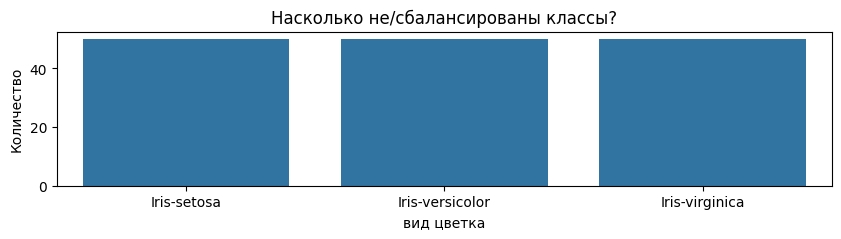

In [ ]:
plt.figure(figsize=(10, 2));sns.countplot(data=df, x="вид цветка")
plt.title("Насколько не/сбалансированы классы?");plt.xlabel("вид цветка");plt.ylabel('Количество');plt.show()

Классы сбалансированы (Если был бы перекос, то мы бы выровняли количество образцов по классам)

In [ ]:
# sm = SMOTEN(random_state=42, k_neighbors=2)
# X_res, y_res = sm.fit_resample(df.drop(['вид цветка'],axis=1), df['вид цветка'] )
# x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, shuffle=True, random_state=42)

В лучших традициях сохраняем **предобработанные признаки**

In [ ]:
x = df.drop(['вид цветка'],axis=1);y_src = df['вид цветка']
df['вид цветка'] = le.fit_transform(y_src)
y = df['вид цветка']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.67, random_state=42, shuffle=False)
x_train.to_csv(f"iris_features_train_v{DATA_VERSION}.csv", index=False)
y_train.to_csv(f"iris_targets_train_v{DATA_VERSION}.csv", index=False)
x_test.to_csv(f"iris_features_test_v{DATA_VERSION}.csv", index=False)
y_test.to_csv(f"iris_targets_test_v{DATA_VERSION}.csv", index=False)

In [ ]:
%%sh
dvc add iris_features_train_v${DATA_VERSION}.csv
dvc add iris_targets_train_v${DATA_VERSION}.csv
dvc add iris_features_test_v${DATA_VERSION}.csv
dvc add iris_targets_test_v${DATA_VERSION}.csv
dvc commit
git add iris_features_train_v${DATA_VERSION}.csv.dvc
git add iris_targets_train_v${DATA_VERSION}.csv.dvc
git add iris_features_test_v${DATA_VERSION}.csv.dvc
git add iris_targets_test_v${DATA_VERSION}.csv.dvc
git add .dvc/config && git commit -m "сохраняем предобработанные признаки"
dvc push


To track the changes with git, run:

	git add iris_features_train_v1.csv.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true

To track the changes with git, run:

	git add .gitignore iris_targets_train_v1.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true

To track the changes with git, run:

	git add iris_features_test_v1.csv.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true

To track the changes with git, run:

	git add iris_targets_test_v1.csv.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true
[master dd6f4b9] сохраняем предобработанные признаки
 4 files changed, 20 insertions(+)
 create mode 100644 iris_features_test_v1.csv.dvc
 create mode 100644 iris_features_train_v1.csv.dvc
 create mode 100644 iris_targets_test_v1.csv.dvc
 create mode 100644 iris_targets_train_v1.csv.dvc
4 files pushed


### Запускаем конвейер

Мы будем сразу с помощью RL библиотеки Optuna подбирать гиперпараметры двух моделей-кандидатов

1) классификатор LightGBM будем обучать CPU

In [ ]:
best_model_lgbm=None
max_accuracy=0
def objective_lgbm(trial):
    global model_lgbm
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'num_leaves': trial.suggest_int('num_leaves', 2, 5),  # Max number of leaves
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Maximum depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Learning rate
    }

    model_lgbm = LGBMClassifier(**params, n_estimators=10)
    fit_params={'categorical_feature': 'auto'}
    model_lgbm.fit(x_train, y_train, **fit_params)
    y_pred = model_lgbm.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    global max_accuracy
    global best_model_lgbm
    if accuracy>=max_accuracy:
      max_accuracy= accuracy
      best_model_lgbm=model_lgbm
      sio.dump(best_model_lgbm, f'/content/best_model_lgbm_v{DATA_VERSION}.skops')

    return accuracy

# Используем алгоритм древовидной оценки Парцена для перебора гиперпараметров классификатора LightGBM
study_lgbm = optuna.create_study(direction='maximize',sampler=TPESampler())
study_lgbm.optimize(objective_lgbm, n_trials=10)

print("LightGBM: лучшие параметры ", study_lgbm.best_params, "\nлучшая точность ", study_lgbm.best_value)

LightGBM: лучшие параметры  {'num_leaves': 5, 'max_depth': 5, 'learning_rate': 0.07150007066733108} 
лучшая точность  0.009900990099009901


2) классификатор XGBoost будем обучать на GPU

In [ ]:
best_modelxgb=None
max_accuracy=0
def objective_xgboost(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'random_state': 42
    }

    modelxgb = xgb.XGBClassifier(**params, n_estimators=100, enable_categorical=True, tree_method="gpu_hist", device="cuda")
    modelxgb.fit(x_train, y_train)

    y_pred = modelxgb.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    global max_accuracy
    global best_modelxgb
    if accuracy>=max_accuracy:
      max_accuracy= accuracy
      best_modelxgb=modelxgb
      sio.dump(best_modelxgb, f'/content/best_modelxgb_v{DATA_VERSION}.skops')

    return accuracy

# Используем алгоритм древовидной оценки Парцена для перебора гиперпараметров классификатора XGBoost
study_xgboost = optuna.create_study(direction='maximize',sampler=TPESampler())
study_xgboost.optimize(objective_xgboost, n_trials=10,show_progress_bar=True)

print("XGBoost:лучшие параметры ", study_xgboost.best_params, "\nлучшая точность ", study_xgboost.best_value)

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-13 15:29:44,601] Trial 0 finished with value: 0.009900990099009901 and parameters: {'max_depth': 5, 'learning_rate': 0.07909176486501177}. Best is trial 0 with value: 0.009900990099009901.
[I 2025-07-13 15:29:44,712] Trial 1 finished with value: 0.009900990099009901 and parameters: {'max_depth': 4, 'learning_rate': 0.0606509489968561}. Best is trial 0 with value: 0.009900990099009901.
[I 2025-07-13 15:29:44,779] Trial 2 finished with value: 0.009900990099009901 and parameters: {'max_depth': 3, 'learning_rate': 0.016673760639079296}. Best is trial 0 with value: 0.009900990099009901.
[I 2025-07-13 15:29:44,843] Trial 3 finished with value: 0.009900990099009901 and parameters: {'max_depth': 3, 'learning_rate': 0.03397356583973423}. Best is trial 0 with value: 0.009900990099009901.
[I 2025-07-13 15:29:44,912] Trial 4 finished with value: 0.009900990099009901 and parameters: {'max_depth': 5, 'learning_rate': 0.09180751206251671}. Best is trial 0 with value: 0.009900990099009901.


автоматически выбираем лучшую из обученных моделей на основании точности и отдаём заказчику модель с артефактами обучения для воспроизводимости в современном безопасном формате skops  

In [ ]:
if study_xgboost.best_value > study_lgbm.best_value:
  print("xgboost лучше !")
  with open('/content/best_params.json', 'w') as f:f.write(json.dumps(study_xgboost.best_params))
else:
  print("lgbm лучше!")
  with open('/content/best_params.json', 'w') as f:f.write(json.dumps(study_lgbm.best_params))

lgbm лучше!


Как и положено - отдаём артефакты для **воспроизводимости**

In [ ]:
%%sh
dvc add best_params.json
dvc add best_modelxgb_v${DATA_VERSION}.skops
dvc add best_model_lgbm_v${DATA_VERSION}.skops
dvc commit
git add best_params.json.dvc .dvc/config && git commit -m "сохраняем артефакты  - модели и достгнутые метрики"
dvc push


To track the changes with git, run:

	git add best_params.json.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true

To track the changes with git, run:

	git add best_modelxgb_v1.skops.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true

To track the changes with git, run:

	git add .gitignore best_model_lgbm_v1.skops.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master a1facb7] сохраняем артефакты  - модели и достгнутые метрики
 1 file changed, 5 insertions(+)
 create mode 100644 best_params.json.dvc
3 files pushed


Берём для продуктивной среды **свежую версию** модели

In [ ]:
!dvc status -c
!rm *.skops  && echo "------------удалили старые файлы модели"
!ls | grep skops
!dvc pull && echo "------------скачали новые файлы модели"
!ls | grep skops
!dvc status -c

Cache and remote 'myremote' are in sync.
------------удалили старые файлы модели
best_model_lgbm_v1.skops.dvc
best_modelxgb_v1.skops.dvc
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
Fetching
Building workspace index          |6.00 [00:00,  509entry/s]
Comparing indexes          |9.00 [00:00, 6.49kentry/s]
Applying changes          |2.00 [00:00,   427file/s]
A       best_modelxgb_v1.skops
A       best_model_lgbm_v1.skops
2 files added
------------скачали новые файлы модели
best_model_lgbm_v1.skops
best_model_lgbm_v1.skops.dvc
best_modelxgb_v1.skops
best_modelxgb_v1.skops.dvc
Cache and remote 'myremote' are in sync.


Запустили в **продуктивной среде** свежую версию модели

In [ ]:
model_in_production = sio.load(f'/content/best_model_lgbm_v{DATA_VERSION}.skops', trusted=sio.get_untrusted_types(file=f'/content/best_model_lgbm_v{DATA_VERSION}.skops'))
predictions = model_in_production.predict(x_test)
print(f"точность на проде: {accuracy_score(y_test, predictions):.4f}")

точность на проде: 0.0099


### Итог:

ни одной ошибки в коде, весь код конвейера отработал безупречно, в продуктивной среде работает свежая версия модели и делает предсказания для пользователей.

In [4]:
display(Textarea(placeholder='''Пожалуйста, прими решение о целесообразности работы такой модели''', description='Ответ:', layout=Layout(width='600px', height='100px')))

Textarea(value='', description='Ответ:', layout=Layout(height='100px', width='600px'), placeholder='Пожалуйста…

# 3. Анализ работы конвейера

In [ ]:
!pip install "numpy<2" -q
!pip install gdown -q
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
%%capture
from IPython.display import Image
from IPython.display import display
from ipywidgets import Textarea, Layout
import sweetviz as sv
import pandas as pd
import gdown
import os
from sklearn.preprocessing import LabelEncoder
import IPython
from sklearn.model_selection import train_test_split
le = LabelEncoder()
url = "https://blogger.googleusercontent.com/img/a/AVvXsEi93rgdaMrXMCyI6mVOrVPONdUbMdslsU1igK7qebnXjrGL8KhJ-proNIaMMoLxKuYYU7ttdVmXeWLkW-3MSeqRA8wkM5dLHV-iz-Klyj9yDGWbJyD6LG7sscYiwvtGH_EFvKXZX8zPDoJtWg_E_nAu2XuMvHJSdEg9eI3izQkRSG7vZeQFsMH61D-zdg=s16000"
output = "/content/data_cascades.jpg"
gdown.download(url, output)

In [ ]:
%%capture
analyze_report = sv.compare([x_train ,"train"],[x_test,"test"])
analyze_report.show_html('analyze.html', open_browser=False)


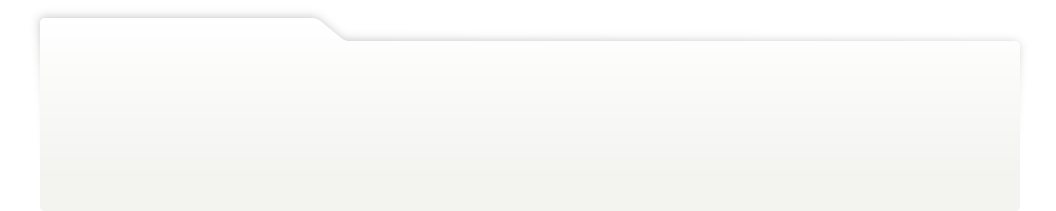
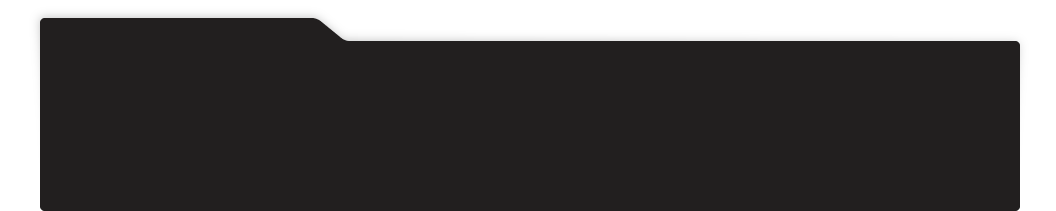
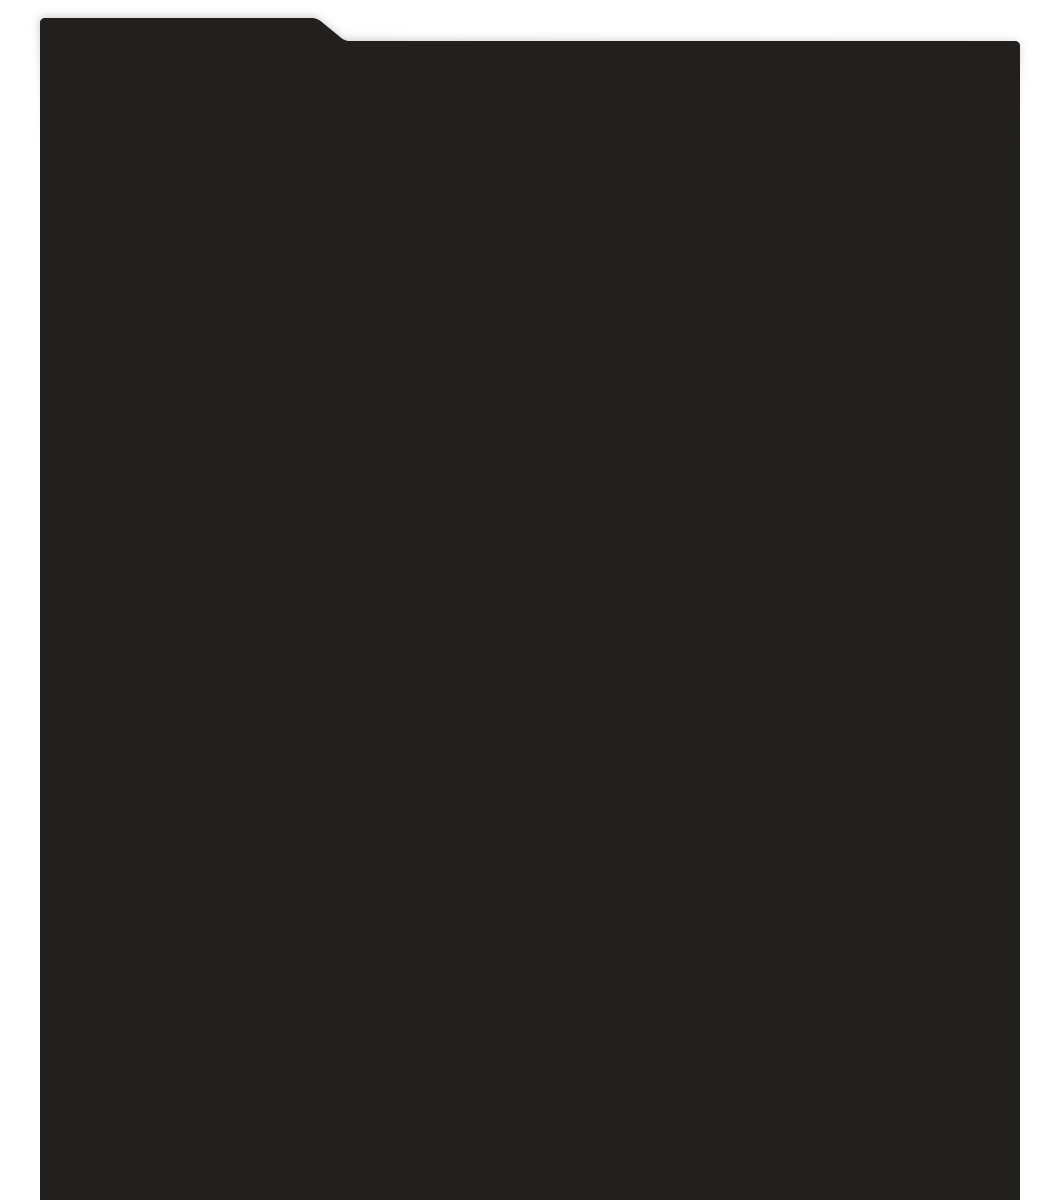
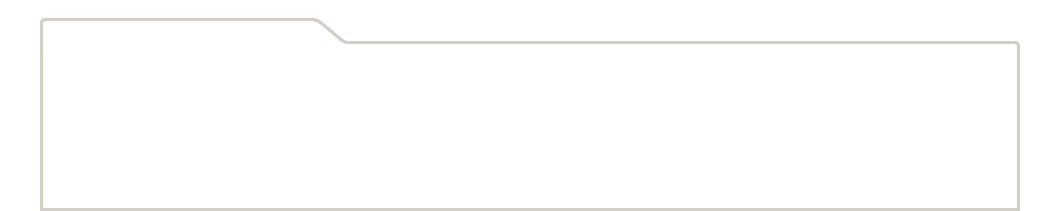
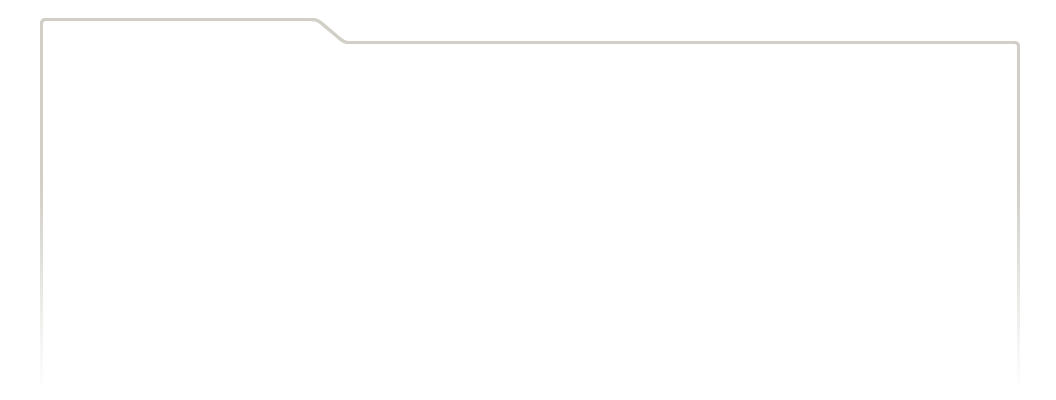
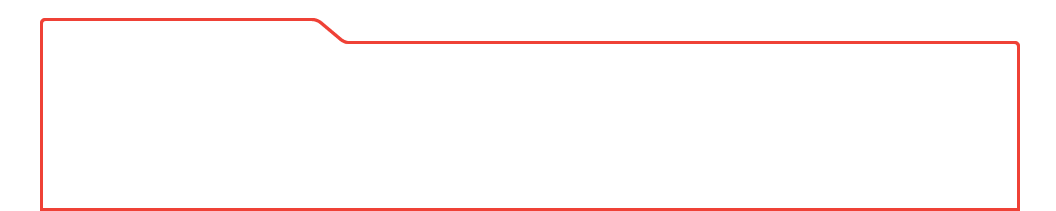
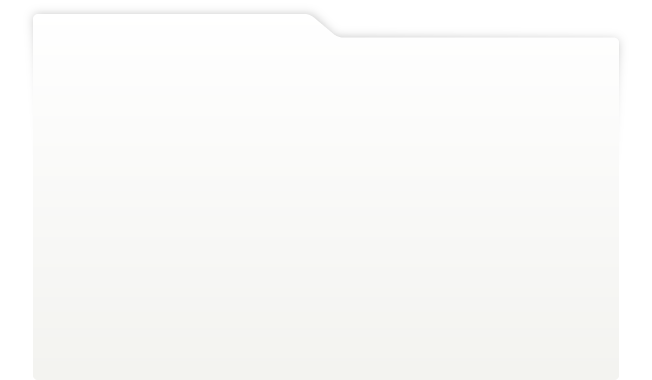
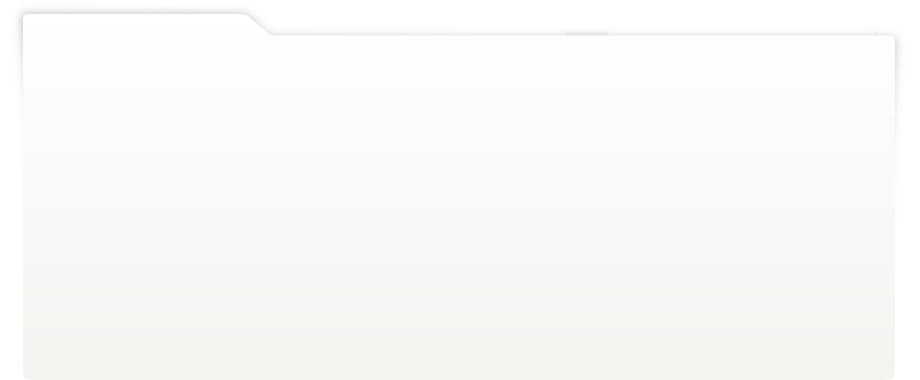
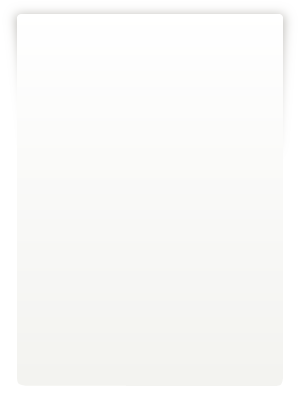
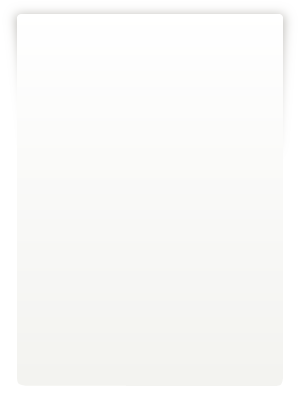
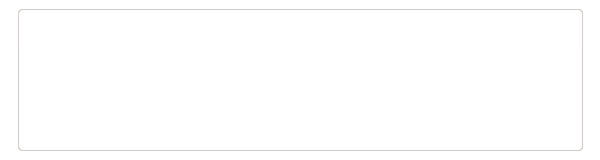
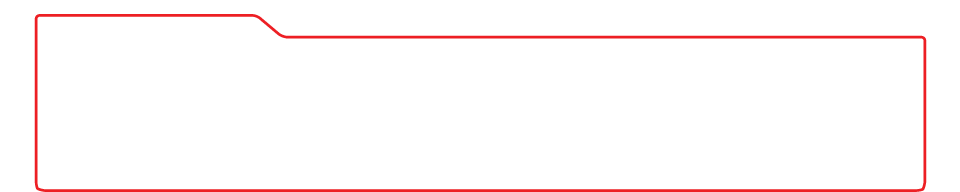
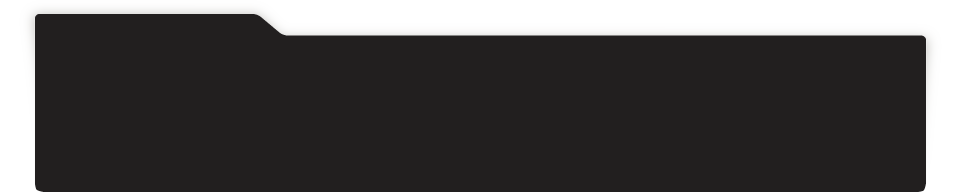
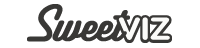
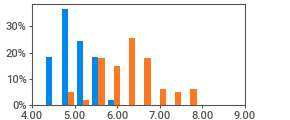
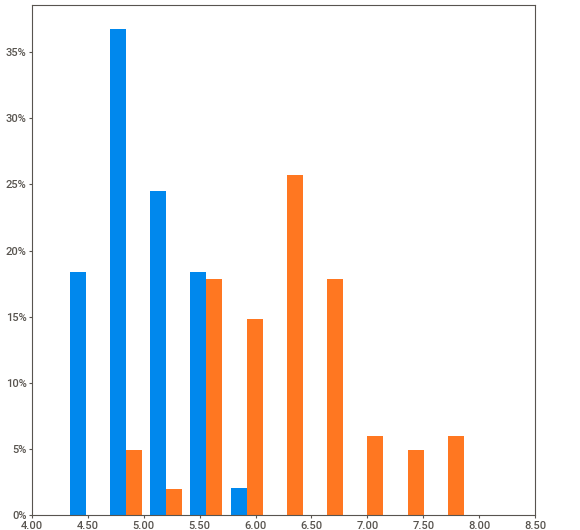
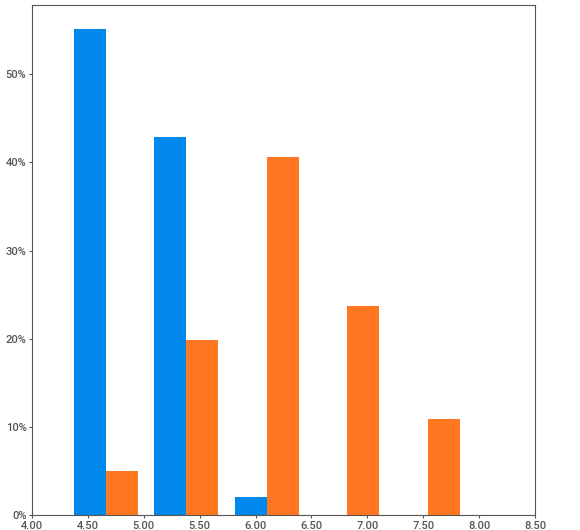
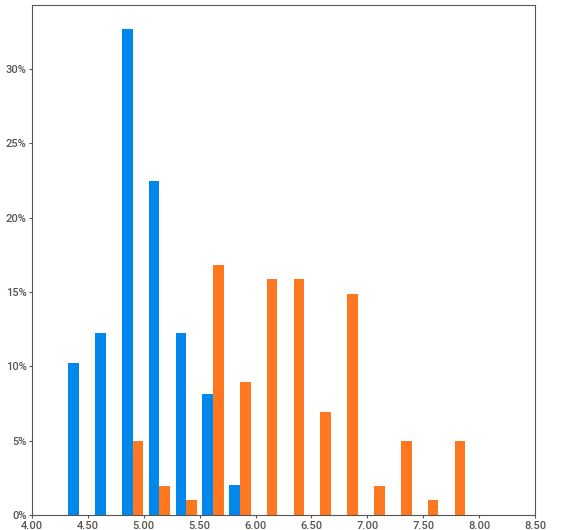
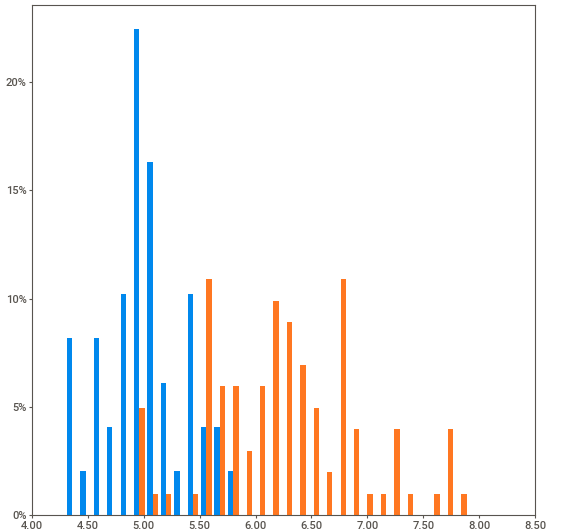
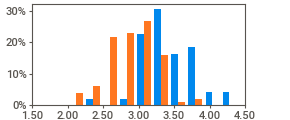
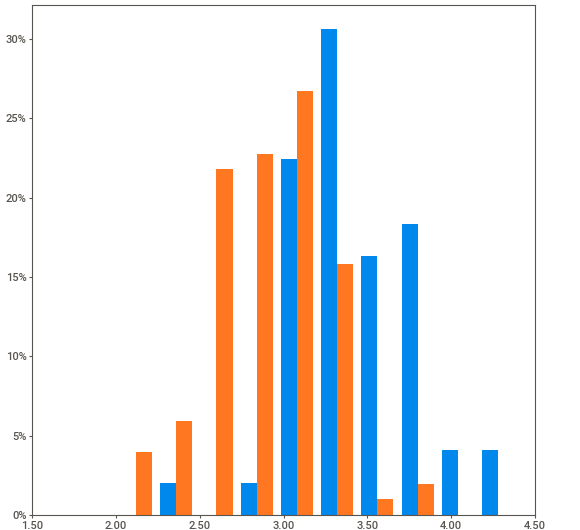
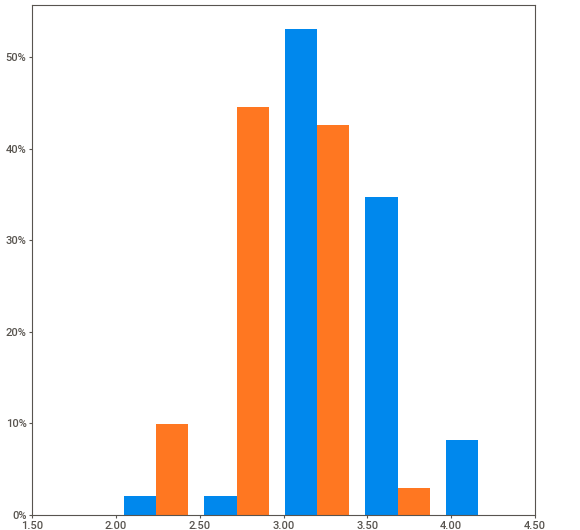
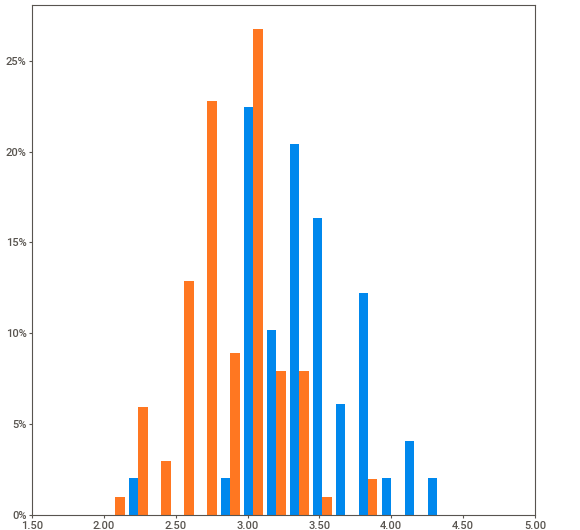
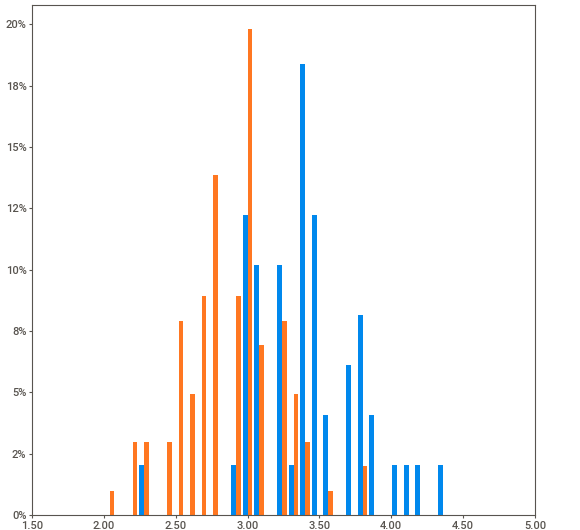
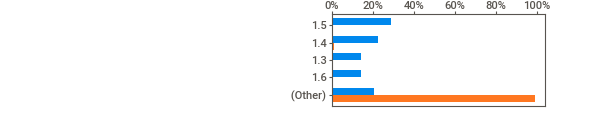
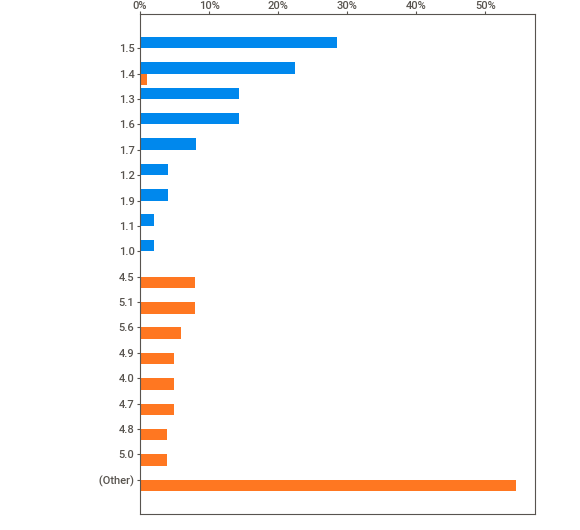
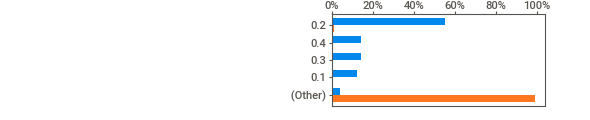
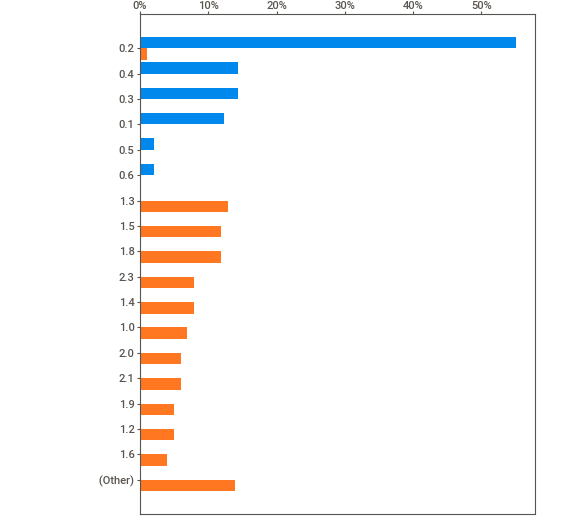
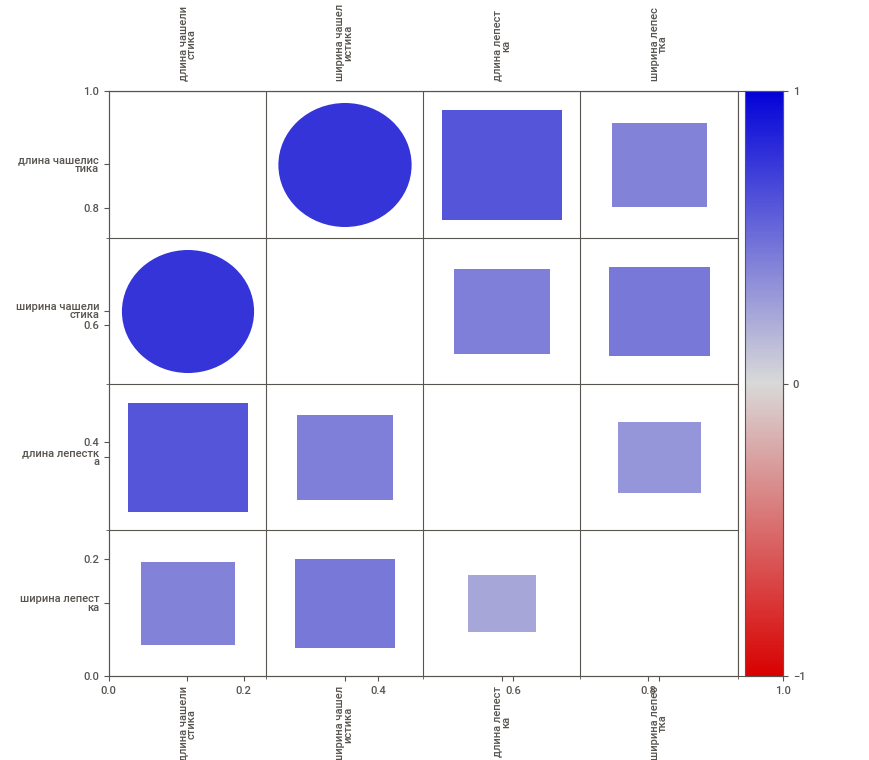
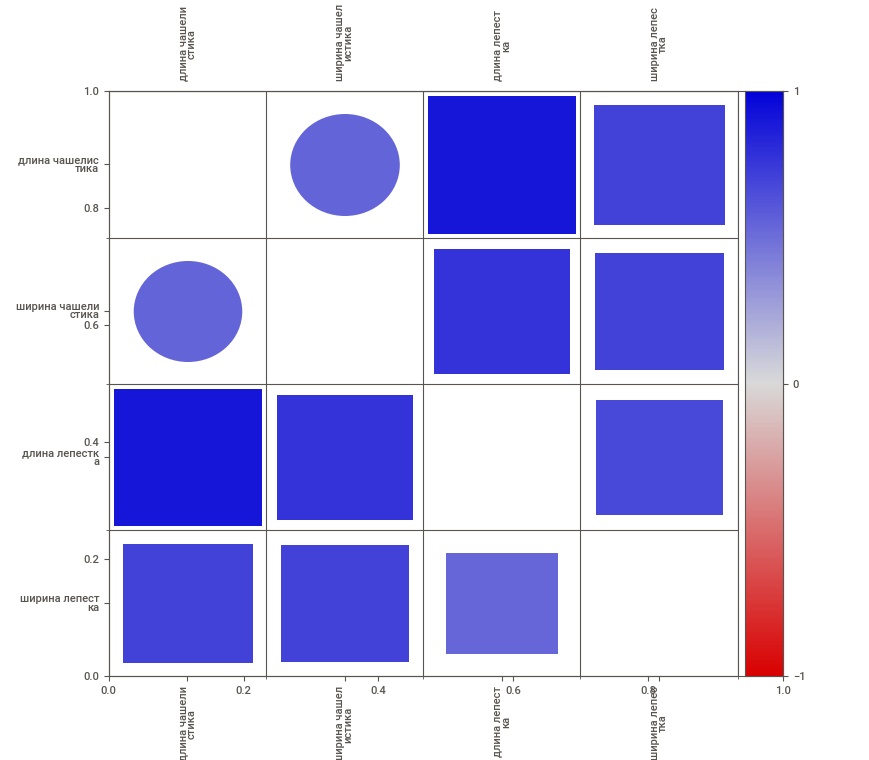

In [ ]:
IPython.display.HTML('analyze.html')

Каскадная ошибка данных - это совокупность событий, приводящих к  негативным последствиям на поздних этапах ML-конвейера из-за проблем с входными данными.


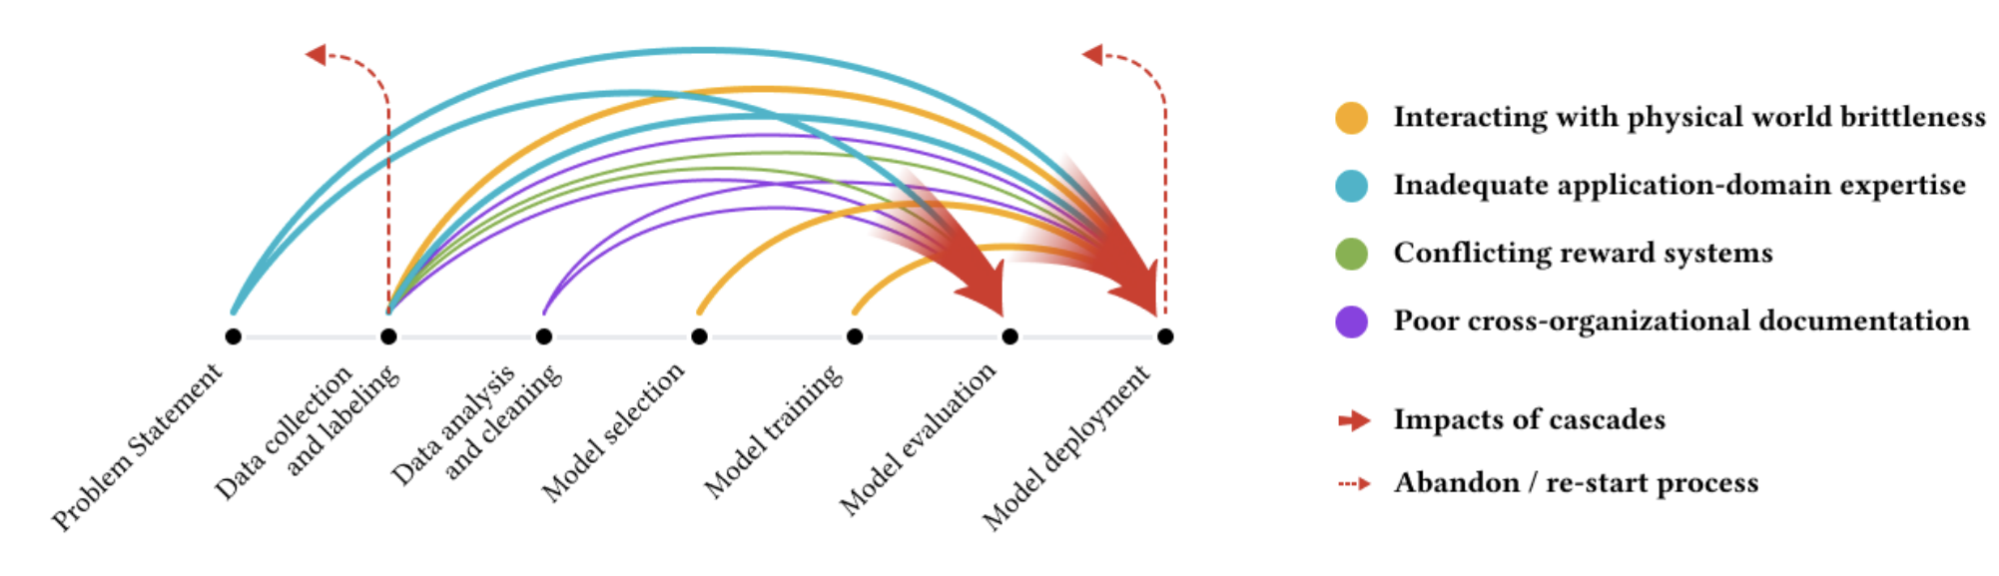

In [ ]:
print("""Каскадная ошибка данных - это совокупность событий, приводящих к  негативным последствиям на поздних этапах ML-конвейера из-за проблем с входными данными.""");Image(filename=output)

In [5]:
display(Textarea(placeholder='''Пожалуйста, подробно изложи своё понимание ситуации:

что произошло ?
почему это произошло ?
как это исправить ?''', description='Ответ:', layout=Layout(width='600px', height='100px')))

Textarea(value='', description='Ответ:', layout=Layout(height='100px', width='600px'), placeholder='Пожалуйста…

In [17]:
# Проверка после исправления

x = df.drop(['вид цветка'],axis=1);y_src = df['вид цветка']
df['вид цветка'] = le.fit_transform(y_src)
y = df['вид цветка']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [19]:
# Проверим точность через модель Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train, y_train)

# 2. Проверяем точность
accuracy = accuracy_score(y_test, model.predict(x_test))
accuracy

1.0

In [ ]:
# Достигли точности 100%